In [4]:
from IPython.display import display
import pandas as pd
import numpy as np
import re


#==============================================================
# 1. LOAD & MERGE DATA
#==============================================================

# Define file path
file_path = "Joined_database.xlsx"


# Read the Excel
df = pd.read_excel(file_path,engine="openpyxl", header=0)

# Inspect first few rows
print("=== HEAD OF DATAFRAME ===")
print(df.columns)
print(df.head(), "\n")

=== HEAD OF DATAFRAME ===
Index(['Account ID', ' Date', 'Amount In', 'Amount Out', 'Balance', 'Type',
       'Desc1|Desc2', 'ExIf', 'FI ID', 'Name', 'Number', 'Credit Limit',
       'Interest Rate', 'Joint', 'Status', 'Open', 'Closed', 'Known since',
       'Total Trxs', '2024-12', '2024-11', '2024-10', '2024-09', '2024-08',
       '2024-07'],
      dtype='object')
   Account ID                 Date    Amount In    Amount Out      Balance  \
0   523319000          Date          Amount In    Amount Out      Balance    
1   523319000          Start Bal                                    $0.00    
2   523319000  2024-10-29 00:00:00      $26.72                     $26.72    
3   523319000  2024-10-29 00:00:00       $1.49                     $28.21    
4   523319000  2024-10-29 00:00:00                    $-1.49       $26.72    

                    Type                                        Desc1|Desc2  \
0   Type                   Desc1|Desc2                                  ...   
1    

In [5]:
#==============================================================
# 2. BASIC CLEANING & DATA PREP
#==============================================================

# 2.1 Standardize column names 
df.rename(columns={
    'Account ID':      'Account_ID',
    'Date':            'Date',
    'Amount In':       'AmountIn',
    'Amount Out':      'AmountOut',
    'Balance':         'Balance',
    'Type':            'Type',
    'Desc1':           'Description1',
    'Desc2':           'Description2',
    'Exif':            'Exit',             
    'FI ID':           'FI_ID',
    'Number':          'Number',
    'Credit Limit':    'CreditLimit',
    'Interest Rate':   'InterestRate',
    'Joint':           'JointAccount',
    'Status':          'Status',
    'Open':            'OpenDate',
    'Closed':          'ClosedDate',
    'Known since':     'KnownSince',
    'Total Trxs':      'TotalTransactions',
    '2024-12':         'Balance_2024_12',
    '2024-11':         'Balance_2024_11',
    '2024-10':         'Balance_2024_10',
    '2024-09':         'Balance_2024_09',
    '2024-08':         'Balance_2024_08',
    '2024-07':         'Balance_2024_07'
}, inplace=True)



df.columns = df.columns.str.strip()



# print(df.head(), "\n")
# 2.2 Convert date column to datetime 
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 2.3 Convert numeric columns from strings (if needed)
for col in ['AmountIn', 'AmountOut', 'Balance']:
    if col in df.columns:
            # Remove non-numeric characters and convert to float
            df[col] = pd.to_numeric(df[col].replace('[\$,]', '', regex=True), errors='coerce')
            # Replace NaN with 0
            df[col].fillna(0, inplace=True)
        

# # 2.4 Sort by date 
df.sort_values(by='Date', inplace=True)

# Drop any rows that have invalid or missing date
df = df.dropna(subset=['Date'])

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)  # remove rows where date couldn't be parsed




# Inspect first few rows
print("=== HEAD OF Cleaned DATAFRAME ===")
# print(df.head(2), "\n")
print(df.columns)


=== HEAD OF Cleaned DATAFRAME ===
Index(['Account_ID', 'Date', 'AmountIn', 'AmountOut', 'Balance', 'Type',
       'Desc1|Desc2', 'ExIf', 'FI_ID', 'Name', 'Number', 'CreditLimit',
       'InterestRate', 'JointAccount', 'Status', 'OpenDate', 'ClosedDate',
       'KnownSince', 'TotalTransactions', 'Balance_2024_12', 'Balance_2024_11',
       'Balance_2024_10', 'Balance_2024_09', 'Balance_2024_08',
       'Balance_2024_07'],
      dtype='object')


<>:49: SyntaxWarning: invalid escape sequence '\$'
<>:49: SyntaxWarning: invalid escape sequence '\$'
/var/folders/v0/302vhr4n5dnbjpj8077_jckw0000gn/T/ipykernel_33677/3990734770.py:49: SyntaxWarning: invalid escape sequence '\$'
  df[col] = pd.to_numeric(df[col].replace('[\$,]', '', regex=True), errors='coerce')
/var/folders/v0/302vhr4n5dnbjpj8077_jckw0000gn/T/ipykernel_33677/3990734770.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
/var/folders/v0/302vhr4n5dnbjpj8077_jckw0000gn/T/ipykernel_33677/3990734770.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [6]:


#==============================================================
# 3. HELPER FUNCTIONS & CATEGORIZATION
#==============================================================
def categorize_transaction(row):
    """
    Categorize each transaction based on description or other fields.
    """
    desc = str(row.get('Desc1|Desc2', '')).lower()
    type_money = str(row.get('Type', '')).lower()
    exit_info = str(row.get('ExIf', '')).strip().lower()
    
    if 'purchase' in desc or 'purchase' in type_money:
        return 'Purchase'
    elif 'mortgage' in desc or 'mortgage' in exit_info:
        return 'Mortgage Payment'
    elif 'credit card' in desc or 'credit card' in exit_info:
        return 'Credit Card'
    elif 'loan' in desc or 'externalloan' in type_money:
        return 'Loan Payment'
    elif any(keyword in desc for keyword in ['deposit', 'payroll', 'salary','pay']):
        return 'Salary Deposit'
    else:
        return 'Other'


df['Category'] = df.apply(categorize_transaction, axis=1)
display(df)



,Account_ID,Date,AmountIn,AmountOut,Balance,Type,Desc1|Desc2,ExIf,FI_ID,Name,...,ClosedDate,KnownSince,TotalTransactions,Balance_2024_12,Balance_2024_11,Balance_2024_10,Balance_2024_09,Balance_2024_08,Balance_2024_07,Category
2,523319000,2024-10-29,26.72,0.00,26.72,TransferOtherUser,|FROM ANONYMOUS 0000267285 SHARE 0001 ...,Received ...,HSUFXNKONE6HHUIFNTLO-0001-Savings,Savings,...,None,2024-10-29,53,$43.39,"$1,020.17",$26.72,$0.00,$0.00,$0.00,Other
3,523319000,2024-10-29,1.49,0.00,28.21,TransferOtherUser,|FROM ANONYMOUS 0000267285 SHARE 0066 ...,Received ...,HSUFXNKONE6HHUIFNTLO-0001-Savings,Savings,...,None,2024-10-29,53,$43.39,"$1,020.17",$26.72,$0.00,$0.00,$0.00,Other
4,523319000,2024-10-29,0.00,-1.49,26.72,,| ...,...,HSUFXNKONE6HHUIFNTLO-0001-Savings,Savings,...,None,2024-10-29,53,$43.39,"$1,020.17",$26.72,$0.00,$0.00,$0.00,Other
322,523319002,2024-10-29,1.49,0.00,1.49,,|,,HSUFXNKONE6HHUIFNTLO-0003-Money Markets,Money Market Savings,...,None,2024-10-29,1,$0.00,$0.00,$1.49,$0.00,$0.00,$0.00,Other
62,523319001,2024-10-29,388.18,0.00,388.18,TransferOtherUser,|FROM ANONYMOUS 0000267285 SHARE 0015 ...,Received ...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,523319001,2024-12-31,3790.42,0.00,5756.13,,PETER PARKER|TYPE: PAY 070147 ID: 9138864001...,...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Salary Deposit
312,523319001,2024-12-31,0.00,-98.77,1965.71,,CONSUMER DEBIT|WHITESELLS AUTOMOTIVE S NEWPOR...,...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Other
338,523319003,2024-12-31,75.00,0.00,1685.99,TransferOwnAccounts,FROM SHARE 0002|REF # 19090901,Linked AcctID 523319001/HSUFXNKONE6HHUIFNTLO-...,HSUFXNKONE6HHUIFNTLO-0001-Mortgage Loans,Home Equity Line of Credit,...,None,2006-10-12,11,$206.42,"$-1,898.32",$0.00,$0.00,$0.00,$0.00,Other
315,523319001,2024-12-31,0.00,-38.74,5642.39,Purchase,#436615611348|COSTCO WHSE #0247 NEWPORT NEWS ...,Costco ...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Purchase


In [5]:
#==============================================================
# 4. CHECK FOR MORTGAGE
#==============================================================
# Strategy:
#   - If there are explicit "Mortgage" strings in the description 

# Identify rows that are labeled as 'Mortgage Payment' in Category
mortgage_payments = df[df['Category'] == 'Mortgage Payment']
display(mortgage_payments)

,Account_ID,Date,AmountIn,AmountOut,Balance,Type,Desc1|Desc2,ExIf,FI_ID,Name,...,ClosedDate,KnownSince,TotalTransactions,Balance_2024_12,Balance_2024_11,Balance_2024_10,Balance_2024_09,Balance_2024_08,Balance_2024_07,Category
74,523319001,2024-11-05,0.0,-100.0,3266.53,TransferOwnAccounts,TO LOAN 0001|REF # 17842316 ...,Linked AcctID 523319003/HSUFXNKONE6HHUIFNTLO-...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Mortgage Payment
78,523319001,2024-11-08,0.0,-1113.1,2104.43,ExternalLoan,WF HOME MTG|TYPE: AUTO PAY ID: 1562287461 ...,"Wells Fargo, Mortgage ...",HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Mortgage Payment
106,523319001,2024-11-19,0.0,-75.0,3734.69,TransferOwnAccounts,TO LOAN 0001|REF # 18142152 ...,Linked AcctID 523319003/HSUFXNKONE6HHUIFNTLO-...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Mortgage Payment
157,523319001,2024-12-02,0.0,-1113.1,4505.06,ExternalLoan,WF HOME MTG|TYPE: AUTO PAY ID: 1562287461 ...,"Wells Fargo, Mortgage ...",HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Mortgage Payment
165,523319001,2024-12-03,0.0,-75.0,3298.84,TransferOwnAccounts,TO LOAN 0001|REF # 18463412 ...,Linked AcctID 523319003/HSUFXNKONE6HHUIFNTLO-...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Mortgage Payment
240,523319001,2024-12-17,0.0,-75.0,3213.45,TransferOwnAccounts,TO LOAN 0001|REF # 18782176 ...,Linked AcctID 523319003/HSUFXNKONE6HHUIFNTLO-...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Mortgage Payment
314,523319001,2024-12-31,0.0,-75.0,5681.13,TransferOwnAccounts,TO LOAN 0001|REF # 19090901 ...,Linked AcctID 523319003/HSUFXNKONE6HHUIFNTLO-...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,None,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Mortgage Payment


In [8]:
#==============================================================
# 5. CHECK IF USER HAS A SALARY (BIWEEKLY DETECTION)
#==============================================================




# 5.1 Parse the inflows data, focusing on deposits > 0
inflows = df[df['AmountIn'] > 0].copy()
# display(inflows)


# create a "Payor" column by extracting everything before the '|'.
def extract_payor(desc):
    if not isinstance(desc, str):
        return None
    parts = desc.split('|', maxsplit=1)
    return parts[0].strip()

inflows['Payor'] = inflows['Desc1|Desc2'].apply(extract_payor)

# 5.2 We'll define a threshold to consider "large deposit" as potential salary
MIN_SALARY_AMOUNT = 500  # e.g. $5,000 min average deposit
BIWEEKLY_TOLERANCE = 3    # +/- 3 days from 14

# We'll store all potential salaries in a list
potential_salaries = []

# Group by Payor, sort by Date, then check for average deposit 
for payor, group in inflows.groupby('Payor'):
    group_sorted = group.sort_values(by='Date')
    # print(group_sorted)
    # Check the average deposit for that payor
    avg_deposit = group_sorted['AmountIn'].mean()
    if avg_deposit < MIN_SALARY_AMOUNT:
        continue  # skip if too small to be considered a salary
    
    
    total_received = group_sorted['AmountIn'].sum()
    num_payments = len(group_sorted)
    
    potential_salaries.append({
        'Payor': payor,
        'AvgDeposit': round(avg_deposit, 2),
        'NumPayments': num_payments,
        'TotalReceived': round(total_received, 2)
    })

# Convert potential_salaries to a DataFrame for display
df_salaries = pd.DataFrame(potential_salaries)

# 5.4 Determine if user has a salary
if not df_salaries.empty:
    has_salary = True
    # For demonstration, let's assume the "main salary" is the largest total received
    top_salary_source = df_salaries.loc[df_salaries['TotalReceived'].idxmax()]
    avg_salary = top_salary_source['AvgDeposit']
    
    print("=== POTENTIAL BIWEEKLY SALARY SOURCES DETECTED ===")
    display(df_salaries)
    print("\nLikely Salary Payor:", top_salary_source['Payor'])
    print("Average Salary Deposit: $", avg_salary)
else:
    has_salary = False
    avg_salary = 0
    print("No recurring biweekly high deposits found. User may not have a salary or the pattern is different.")



=== POTENTIAL BIWEEKLY SALARY SOURCES DETECTED ===


,Payor,AvgDeposit,NumPayments,TotalReceived
0,,743.43,9,6690.88
1,PETER PARKER,2174.47,6,13046.83



Likely Salary Payor: PETER PARKER
Average Salary Deposit: $ 2174.47


In [9]:

#==============================================================
# 6. ONGOING PROJECT?
#==============================================================
# We might guess a "project" if we see repeated outflows to the same vendor
# with a pattern like "Project," "Remodel," "Construction," "Kickstarter," etc.
# This is very data-dependent. We'll do a naive text search:
project_keywords = ['project', 'remodel', 'renovation', 'kickstarter', 'crowdfunding']
project_regex = '|'.join(project_keywords)

df['IsProject'] = df['Desc1|Desc2'].str.contains(project_regex, case=False, na=False)
has_project = df['IsProject'].any()
print(df['IsProject'] )

2      False
3      False
4      False
322    False
62     False
       ...  
313    False
312    False
338    False
315    False
339    False
Name: IsProject, Length: 319, dtype: bool


In [10]:
df_credit = df[df['Category']=='Credit Card']
display(df_credit)



def extract_name_before_card(text):
    """
    Returns the word/phrase immediately before "CARD".
    For example, 
      "CITI CARD ONLINE|TYPE: PAYMENT..." -> "CITI"
    If nothing is found, returns None.
    """
    if not isinstance(text, str):
        return None
    
    # Regex explanation:
    # (.*?)  -> capture any characters (non-greedy)
    # \s+CARD -> that are followed by whitespace and then "CARD"
    # re.IGNORECASE makes "CARD" case-insensitive
    pattern = re.compile(r'(.*?)\s+CARD', re.IGNORECASE)
    match = pattern.search(text)
    
    if match:
        # group(1) is everything before the word "CARD"
        return match.group(1).strip()
    else:
        return None

print(df_credit['Desc1|Desc2'])
df_credit['ExtractedName'] = df_credit['Desc1|Desc2'].apply(extract_name_before_card)
display(df_credit[['Desc1|Desc2', 'ExtractedName']].head())

card_usage = df_credit.groupby('ExtractedName')['AmountOut'].mean()
print("Average Payment by Card:")
print(card_usage)



,Account_ID,Date,AmountIn,AmountOut,Balance,Type,Desc1|Desc2,ExIf,FI_ID,Name,...,KnownSince,TotalTransactions,Balance_2024_12,Balance_2024_11,Balance_2024_10,Balance_2024_09,Balance_2024_08,Balance_2024_07,Category,IsProject
72,523319001,2024-11-04,0.0,-1000.00,3445.22,ExternalLoan,CITI CARD ONLINE|TYPE: PAYMENT ID: CITICTP ...,"Citi Bank, White Label Credit Card ...",HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Credit Card,False
156,523319001,2024-12-02,0.0,-299.53,5618.16,ExternalLoan,CITI CARD ONLINE|TYPE: PAYMENT ID: CITICTP ...,"Citi Bank, White Label Credit Card ...",HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,2024-10-29,254,$-753.60,"$1,464.81","$4,931.18",$0.00,$0.00,$0.00,Credit Card,False


72      CITI CARD ONLINE|TYPE: PAYMENT  ID: CITICTP  ...
156     CITI CARD ONLINE|TYPE: PAYMENT  ID: CITICTP  ...
Name: Desc1|Desc2, dtype: object


/var/folders/v0/302vhr4n5dnbjpj8077_jckw0000gn/T/ipykernel_33677/3774036752.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_credit['ExtractedName'] = df_credit['Desc1|Desc2'].apply(extract_name_before_card)


,Desc1|Desc2,ExtractedName
72,CITI CARD ONLINE|TYPE: PAYMENT ID: CITICTP ...,CITI
156,CITI CARD ONLINE|TYPE: PAYMENT ID: CITICTP ...,CITI


Average Payment by Card:
ExtractedName
CITI   -649.765
Name: AmountOut, dtype: float64


In [11]:
#==============================================================
# 8. WHO IS THE MOBILE PHONE PROVIDER?
#==============================================================
phone_providers = [
    'Verizon',
    'T-Mobile',
    'AT&T',
    'Sprint',
    'Boost',
    'Cricket',
    'U.S. Cellular',
    'Metro by T-Mobile',
    'Google Fi',
    'TracFone',
    'Straight Talk',
    'Xfinity Mobile',
    'Spectrum Mobile'
]

provider_regex = '|'.join(phone_providers)

# Mark rows that reference a known provider in Desc1|Desc2
df['IsPhoneBill'] = df['Desc1|Desc2'].str.contains(provider_regex, case=False, na=False)
possible_bills = df[df['IsPhoneBill'] == True]

# display(possible_bills)

if len(possible_bills) > 0:
    # Identify which providers appear, collecting them into a list
    user_providers = []
    for desc in possible_bills['Desc1|Desc2']:
        for p in phone_providers:
            if p.lower() in desc.lower():
                user_providers.append(p)
    user_providers = list(set(user_providers))  # get unique providers

    print("Providers found in the ledger: ", user_providers)
    
    # Now show a DataFrame of the phone-bill payments (assuming AmountOut is the payment)
    phone_payments = possible_bills[possible_bills['AmountOut'] < 0].copy()
    phone_payments['PaymentAmount'] = phone_payments['AmountOut'].abs()

    print("\n=== PHONE BILL PAYMENTS (Negative Outflows) ===")
    display(phone_payments[['Date', 'Desc1|Desc2', 'AmountOut', 'PaymentAmount']])
    mobile_avg_bill = phone_payments['PaymentAmount'].mean()
    print("Average Mobile Bill: ",mobile_avg_bill)
else:
    user_providers = []
    print("No phone providers found in the data.")

Providers found in the ledger:  ['Verizon']

=== PHONE BILL PAYMENTS (Negative Outflows) ===


,Date,Desc1|Desc2,AmountOut,PaymentAmount
178,2024-12-05,#434027101367|VERIZON BILL PAYMENT VERIZON.CO...,-89.99,89.99
263,2024-12-20,#435521103285|VERIZON*RECURRING PAY 800-VERIZ...,-119.99,119.99


Average Mobile Bill:  104.99


3.10.0


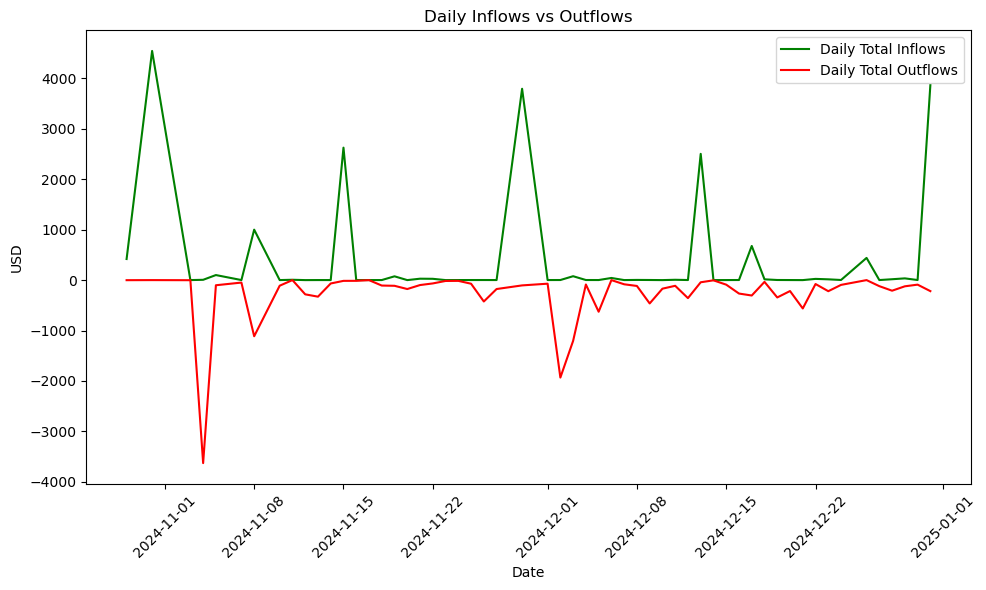

In [12]:
#==============================================================
# 9. VISUALIZE
#==============================================================
# plot total inflows and outflows over time

import matplotlib.pyplot as plt



plt.figure(figsize=(10,6))
df_daily = df.groupby('Date').agg({'AmountIn':'sum','AmountOut':'sum'}).reset_index()
plt.plot(df_daily['Date'], df_daily['AmountIn'], label='Daily Total Inflows', color='green')
plt.plot(df_daily['Date'], df_daily['AmountOut'], label='Daily Total Outflows', color='red')
plt.title('Daily Inflows vs Outflows')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




/var/folders/v0/302vhr4n5dnbjpj8077_jckw0000gn/T/ipykernel_33677/3388217093.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spending['PaymentAmount'] = df_spending['AmountOut'].abs()


,Account_ID,Date,AmountIn,AmountOut,Balance,Type,Desc1|Desc2,ExIf,FI_ID,Name,...,Balance_2024_10,Balance_2024_09,Balance_2024_08,Balance_2024_07,Category,IsProject,IsPhoneBill,Purchase_Source,YearMonth,shopping_cat
2,523319000,2024-10-29,26.72,0.00,26.72,TransferOtherUser,|FROM ANONYMOUS 0000267285 SHARE 0001 ...,Received ...,HSUFXNKONE6HHUIFNTLO-0001-Savings,Savings,...,$26.72,$0.00,$0.00,$0.00,Other,False,False,Other,2024-10,Other
3,523319000,2024-10-29,1.49,0.00,28.21,TransferOtherUser,|FROM ANONYMOUS 0000267285 SHARE 0066 ...,Received ...,HSUFXNKONE6HHUIFNTLO-0001-Savings,Savings,...,$26.72,$0.00,$0.00,$0.00,Other,False,False,Other,2024-10,Other
4,523319000,2024-10-29,0.00,-1.49,26.72,,| ...,...,HSUFXNKONE6HHUIFNTLO-0001-Savings,Savings,...,$26.72,$0.00,$0.00,$0.00,Other,False,False,Other,2024-10,Other
322,523319002,2024-10-29,1.49,0.00,1.49,,|,,HSUFXNKONE6HHUIFNTLO-0003-Money Markets,Money Market Savings,...,$1.49,$0.00,$0.00,$0.00,Other,False,False,Other,2024-10,Other
62,523319001,2024-10-29,388.18,0.00,388.18,TransferOtherUser,|FROM ANONYMOUS 0000267285 SHARE 0015 ...,Received ...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,"$4,931.18",$0.00,$0.00,$0.00,Other,False,False,Other,2024-10,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,523319001,2024-12-31,3790.42,0.00,5756.13,,PETER PARKER|TYPE: PAY 070147 ID: 9138864001...,...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,"$4,931.18",$0.00,$0.00,$0.00,Other,False,False,Other,2024-12,Other
312,523319001,2024-12-31,0.00,-98.77,1965.71,,CONSUMER DEBIT|WHITESELLS AUTOMOTIVE S NEWPOR...,...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,"$4,931.18",$0.00,$0.00,$0.00,Other,False,False,Other,2024-12,Other
338,523319003,2024-12-31,75.00,0.00,1685.99,TransferOwnAccounts,FROM SHARE 0002|REF # 19090901,Linked AcctID 523319001/HSUFXNKONE6HHUIFNTLO-...,HSUFXNKONE6HHUIFNTLO-0001-Mortgage Loans,Home Equity Line of Credit,...,$0.00,$0.00,$0.00,$0.00,Other,False,False,Other,2024-12,Other
315,523319001,2024-12-31,0.00,-38.74,5642.39,Purchase,#436615611348|COSTCO WHSE #0247 NEWPORT NEWS ...,Costco ...,HSUFXNKONE6HHUIFNTLO-0002-Checking,MyDesign Checking,...,"$4,931.18",$0.00,$0.00,$0.00,Groceries / Warehouse Clubs,False,False,Groceries / Warehouse Clubs,2024-12,Groceries / Warehouse Clubs


/var/folders/v0/302vhr4n5dnbjpj8077_jckw0000gn/T/ipykernel_33677/3388217093.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spending['YearMonth'] = df_spending['Date'].dt.to_period('M')


=== MONTHLY SPENDING BY CATEGORY ===
shopping_cat  Convenience / Discount  Dining  Financial / Utility   \
YearMonth                                                            
2024-11                        57.14    8.43                100.95   
2024-12                       146.88   64.41                104.66   

shopping_cat  Groceries / Warehouse Clubs  Hardware / Home Improvement  Online  
YearMonth                                                                       
2024-11                            720.17                         0.00  501.30  
2024-12                           1356.38                        70.48  708.16  


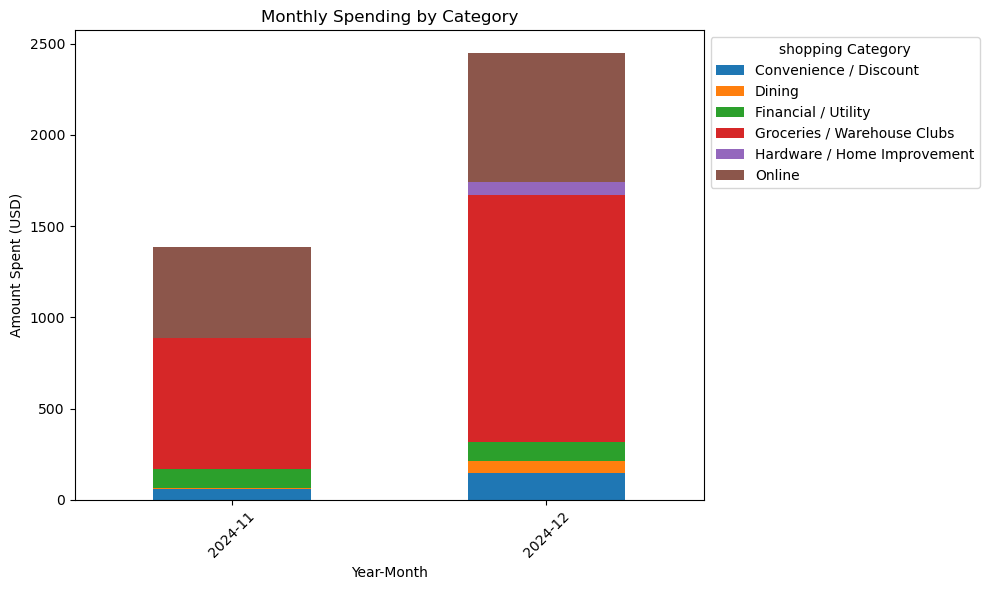

In [43]:
category_keywords = {
    'Groceries / Warehouse Clubs': [
        'harris teeter',
        'trader joe',
        'food lion',
        'lidl',
        'costco',
        'sam\'s club',
        'walmart'
    ],
    'Online': [
        'amazon',
        'apple',
        'best buy'
    ],
    'Hardware / Home Improvement': [
        'ace hardware',
        'lowe\'s'
    ],
    'Convenience / Discount': [
        '7-eleven',
        'family dollar',
        'dollar tree',
        'ollie\'s bargain'
    ],
    'Dining': [
        'blaze pizza',
        'first watch',
        'virginia abc'
    ],
    'Financial / Utility ': [
        'citi bank',        # credit card references
        'wells fargo',      # mortgage references
        'dominion energy',  # utility
        'gofundme'          # crowdfunding/donation
    ]
}

def assign_category(desc):
    if not isinstance(desc, str):
        return 'Other'
    desc_lower = desc.lower()
    for cat, keywords in category_keywords.items():
        for kw in keywords:
            if kw in desc_lower:
                return cat
    return 'Other'



# 2) APPLY TO DATAFRAME
# Assume df is your merged DataFrame
df['shopping_cat'] = df['Desc1|Desc2'].apply(assign_category)
df_spending = df[df['shopping_cat'] != 'Other']
df_spending['PaymentAmount'] = df_spending['AmountOut'].abs()

display(df)

# 3) MONTHLY SPENDING
df_spending['YearMonth'] = df_spending['Date'].dt.to_period('M')
monthly_spend = df_spending.groupby(['YearMonth','shopping_cat'], as_index=False)['PaymentAmount'].sum()
monthly_pivot = monthly_spend.pivot(index='YearMonth', columns='shopping_cat', values='PaymentAmount').fillna(0)

print("=== MONTHLY SPENDING BY CATEGORY ===")
print(monthly_pivot)

# 4) PLOT
monthly_pivot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Monthly Spending by Category')
plt.xlabel('Year-Month')
plt.ylabel('Amount Spent (USD)')
plt.xticks(rotation=45)
plt.legend(title='shopping Category', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

=== Grocery Spend by Store ===
ExIf
Costco                                                                                      1576.60
Harris Teeter Good \t                                                                        206.40
Food Lion                                                                                    131.22
Trader Joe's                                                                                  96.42
Lidl                                                                                          64.12
Sam's Club                                                                                     1.79
Costco Refunded                                                                                0.00
Harris Teeter Good \t Refunded                                                                 0.00
Name: AmountOut, dtype: float64


/var/folders/v0/302vhr4n5dnbjpj8077_jckw0000gn/T/ipykernel_33677/2746375007.py:39: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


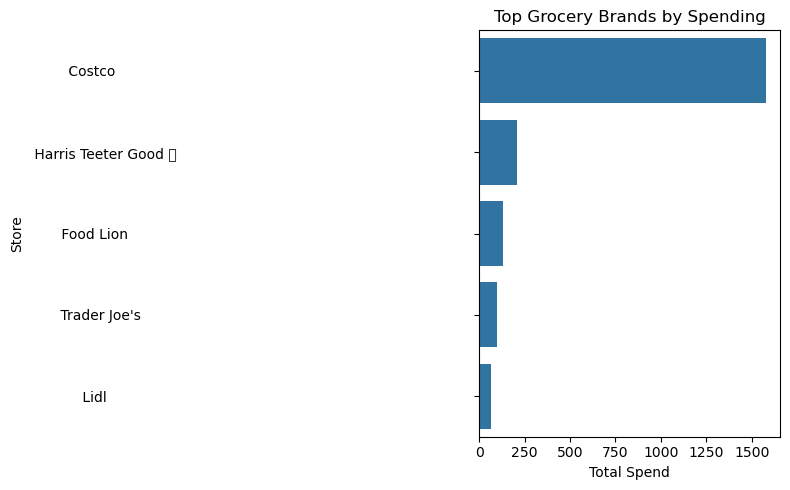

In [46]:
import seaborn as sns



# 1) Filter rows whose shopping_cat is in grocery_stores
df_groceries = df[df['shopping_cat']=='Groceries / Warehouse Clubs']


# 2) Sum total spending for each grocery store
grocery_spend = (
    df_groceries
    .groupby('ExIf')['AmountOut']
    .sum()
    .abs()
    .sort_values(ascending=False)
)

print("=== Grocery Spend by Store ===")
print(grocery_spend)




# Plot top grocery brands
if not grocery_spend.empty:
    top_grocery = grocery_spend.head(5)  # top 5 stores if you like
    df_grocery_plot = top_grocery.reset_index()
    df_grocery_plot.columns = ['Store', 'Spending']
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        y="Store", 
        x="Spending", 
        data=df_grocery_plot, 
        orient='h' 
    )
    plt.title("Top Grocery Brands by Spending")
    plt.xlabel("Total Spend")
    plt.ylabel("Store")
    plt.tight_layout()
    plt.show()
else:
    print("No grocery stores found in data.")

